In [0]:
!pip install tensorboardX

In [0]:
! pip freeze

absl-py==0.7.1
alabaster==0.7.12
albumentations==0.1.12
altair==3.0.1
astor==0.8.0
astropy==3.0.5
atari-py==0.1.7
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.7
autograd==1.2
Babel==2.6.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
bokeh==1.0.4
boto==2.49.0
boto3==1.9.154
botocore==1.12.154
Bottleneck==1.2.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.0
certifi==2019.3.9
cffi==1.12.3
chainer==5.4.0
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.1.3
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.14.6
cvxopt==1.2.3
cvxpy==1.0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.7
cytoolz==0.9.0.1
daft==0.0.4
dask==1.1.5
dataclasses==0.6
datascience==0.10.6
decorator==4.4.0
defusedxml==0.6.0
dill==0.2.9
distributed==1.25.3
Django==2.2.1
dlib==19.16.0
dm-sonnet==1.32
docopt==0.6.2
docutils==0.14
dopamine-rl==1.0.5
easydict==1.9
ecos=

In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [0]:
## It is not necessary that you understand the code in this file, 
## as it is only used for visualization purposes.


import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [0]:
def cifar10_data():
    
    compose = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    out_dir = './dataset'
    return datasets.CIFAR10(root = out_dir, train=True, transform=compose, download=True)
# Load data
data = cifar10_data()

# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=300, shuffle=True)

# Num batches
num_batches = len(data_loader)

  0%|          | 0/170498071 [00:00<?, ?it/s]

100%|█████████▉| 170205184/170498071 [00:28<00:00, 5358649.76it/s]

In [0]:
class DiscriminatorNet(torch.nn.Module): #nn.Module: base class for all neural network modules.
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__() #initializing the discriminator network (DN)
        n_features = 3072                        #input of DN
        n_out = 1                                #output of DN -> scalar (probability)
        
        self.hidden0 = nn.Sequential(            #first hidden layer 
            nn.Linear(n_features, 1024),         #applies a linear transformation to the incoming data -> bigger to smaller
            nn.LeakyReLU(0.2),                   #it allows a small gradient
            nn.Dropout(0.3)                      #regularization technique: prevents overfitting
                                                 #randomly selected neurons are ignored during training. 
                                                 #They are “dropped-out” randomly. This means that their 
                                                 #contribution to the activation of downstream neurons 
                                                 #is temporally removed on the forward pass and any weight 
                                                 #updates are not applied to the neuron on the backward pass.
        )
        self.hidden1 = nn.Sequential(            #second hidden layer
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(            #third hidden layer
            nn.Linear(512, 256),                 
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(                #output layer
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()                   #outputs a number between 0-1
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

discriminator = DiscriminatorNet()              #activate DN -> It starts with an image and will make it smaller everytime
                                                #until it outputs a single number (probability)

In [0]:
def images_to_vectors(images):                  #transform Cifar10 images to vectors
    return images.view(images.size(0), 3072)

def vectors_to_images(vectors):                #transform vectors to images Cifar10
    return vectors.view(vectors.size(0), 3, 32, 32)

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()   #initialize the generator network
        n_features = 300                       #receives a sample noise with dimension 300
        n_out = 3072                           #outputs a vector with 3072 features (synthetic/fake images)
        
        self.hidden0 = nn.Sequential(          #first hidden layer
            nn.Linear(n_features, 456),        #from smaller to bigger
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(          #second hidden layer
            nn.Linear(456, 612),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(          #third hidden layer
            nn.Linear(612, 2024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(              #output layer: image
            nn.Linear(2024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

generator = GeneratorNet()                     #activates GN -> begins with a sample of the noise dimension 
                                               # and outputs fake image with n_features dimension

In [0]:
def noise(size):  #generates noise 
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 300))
    return n

In [0]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)  # Method for Stochastic Optimization
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [0]:
loss = nn.BCELoss()  #Creates a criterion that measures the Binary Cross Entropy between the target and the output
                     #targets 'y' should be numbers between 0 and 1.

In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data): #training discriminator with real and fake data
    N = real_data.size(0)   
    # Reset gradients
    optimizer.zero_grad()   #when you start your training loop, ideally you should zero out the gradients 
                            #so that you do the parameter update correctly. 
                            #Else the gradient would point in some other directions than the intended direction towards the minimum
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data) #probability of classifying a real image as real
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) ) #error
    error_real.backward()                               #backpropagates the error

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data) #probability of classifying a fake image as real
    
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()   # performs a parameter update based on the current gradient 
                       #(stored in .grad attribute of a parameter) and the update rule. 
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [0]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0) 
    # Reset gradients
    optimizer.zero_grad()  #when you start your training loop, ideally you should zero out the gradients 
                            #so that you do the parameter update correctly. 
                            #Else the gradient would point in some other directions than the intended direction towards the minimum 

    # Sample noise and generate fake data
    prediction = discriminator(fake_data) #probability of classifying a fake image as real

    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N)) 
    error.backward()

    # Update weights with gradients
    optimizer.step()

    # Return error
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

d_error_t = []
g_error_t = []
dt = []
gt = []
t=[]
conf_mat = np.zeros((2, 2))

# Create logger instance
logger = Logger(model_name='VGAN', data_name='CIFAR10')

# Total number of epochs to train
num_epochs = 1

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        #N=300
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch)) #transform real data to vectors

        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        #fake_data = generator(noise(N)).detach()            #fake data form the generator and noise
        fake_data = X[0][0]
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator

        # Generate fake data
        #fake_data = generator(noise(N))
        fake_data = X[0][0]
        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches) #visualizing

        # Display Progress every few batches
        if (n_batch) % 167 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data

            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            
            dt.append(d_pred_real.mean())
            gt.append(d_pred_fake.mean())
            
            t.append(epoch)
            #d_error_t += [d_error.data.cpu().numpy()] 
            #g_error_t += [g_error.data.cpu().numpy()]
            #dt += [d_error.item()]
            #gt += [g_error.item()]
            #t = [100,200,300,400,500,600]
            
            
            #plt.plot(d_error_t, t)
            #plt.show()
            
            
            
        #if (d_pred_real.mean() >= 0.5):
         # conf_mat[0][0] +=1
        #else:
         # conf_mat[0][1] +=1
        #if (d_pred_fake.mean() >= 0.4):
         # conf_mat[1][0] += 1
        #else:
         # conf_mat[1][1] += 1
        #print (conf_mat)
            
    

AttributeError: ignored

In [0]:
prob_real = []
prob_fake = []

for i in range(len(dt)):
  prob_real.append(dt[i].item())
  
for i in range(len(gt)):
  prob_fake.append(gt[i].item())

In [0]:
df = pd.DataFrame({'Prob. DN with real image': prob_real,'Prob. DN with fake image': prob_fake}, index=t)

Text(0, 0.5, 'Probability')

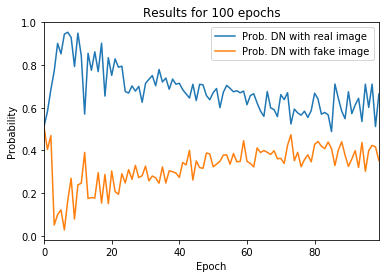

In [0]:
line = df.plot(kind = 'line', title = 'Results for 100 epochs')
line.set_xlabel("Epoch")
line.set_ylabel('Probability')

In [0]:
from keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
import tensorflow as tf
import itertools

(x_train, Y_train), (x_test, y_test) = cifar10.load_data()

Imgen = ImageDataGenerator(rotation_range=90, width_shift_range=1.0, height_shift_range=1.0, brightness_range=(1,2))
X = []
for j in range(1000):
  iterImage = Imgen.flow(np.expand_dims(x_train[j,:,:,:], axis=0))
  i = [next(iterImage) for i in range(1)]
  X  += i
  
  
#for j in range(100):
 # iterImage = Imgen.flow(np.expand_dims(x_train[j,:,:,:], axis=0))
 # h = [next(iterImage) for l in range(1)]
  #print(h[0][0].shape)
  #np.array(list(itertools.zip_longest(h, fillvalue=0))).T
 # i = h[0][0].reshape(1,3072)
 # X  = tf.concat([X,i],0)

Using TensorFlow backend.


In [0]:
len(x)

1

In [0]:
x = Variable(torch.from_numpy(X[:300][0]))
fake_data = x.reshape(1,3072)
d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([300, 1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


ValueError: ignored

In [0]:
loader = torch.utils.data.DataLoader(X[:], batch_size=100, shuffle=True)

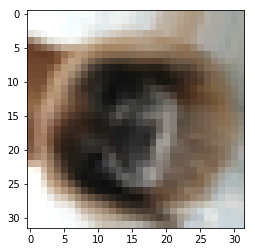

In [0]:
import numpy as np
plt.imshow((X[999][0]).astype(np.uint8))
plt.show()